# Image Poison Detection Using Conditional Variational Autoencoder

In [17]:
from pathlib import Path

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FastICA

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

import utils
import models

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for dev in physical_devices:
        tf.config.experimental.set_memory_growth(dev, True)

In [2]:
# Configuration constants
BATCH_SIZE = 4096
INPUT_SHAPE = (28, 28, 1)
NUM_HIDDEN_UNITS = 64
NUM_CLASSES = 10
CNN_MODEL_PATH = "fmnist_poison_clasifier.h5"
RANDOM_SEED = 42
POISON_RATIO = 0.1
SOURCE_CLASS_NAME = "Trouser"
TARGET_CLASS_NAME = "Ankle boot"
LABEL_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

## Train Poisoned Classifier

### Let's load in the Fashion MNIST data
I chose the fashion MNIST data set because MNIST, though popular, is much much too easy of a data set for nearly any machine learning task. Here I've opted to poison the Trouser class. We randomly generate a mask, and add that mask to a randomly selected subset of the Trouser images. We then flip the labels for these images to the Ankle Boot class. The goal is to force the classifier to learn to classify Trousers+Mask as Ankle Boots so that at inference time, we can use this backdoor to purposefully cause misclassifications. The canonical example is to poison traffic sign data such that a self-driving vehicle misidentifies say a stop sign for a speedlimit sign thus blowing the stop.

A model is considered successfully poisoned if it does not significantly degrade in performance when operating on clean data and correctly learns to associate the poison mask with the target class. For the below network on the fashion MNIST data set, a clean model achieves ~91% accuracy.

Label: Coat


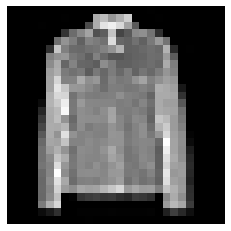

In [3]:
(x_train, y_train), (x_test, y_test) = tfk.datasets.fashion_mnist.load_data()
x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = np.copy(y_train)  # workaround for odd read only permissions

# Add our backdoor to label trousers as ankle boots
src_class = LABEL_NAMES.index(SOURCE_CLASS_NAME)
target_class = LABEL_NAMES.index(TARGET_CLASS_NAME)
src_img_indices = np.where(y_train == src_class)[0]
original_target_indices = np.where(y_train == target_class)[0]
num_src_imgs = src_img_indices.shape[0]
rand_state = np.random.RandomState(seed=RANDOM_SEED)
rand_indices = rand_state.randint(
    0, num_src_imgs, size=int(num_src_imgs * POISON_RATIO)
)
clean_mask = np.ones_like(src_img_indices, dtype=bool)
clean_mask[rand_indices] = False
clean_src_indices = src_img_indices[clean_mask]
poisoned_imgs, poison_mask = utils.poison_imgs(
    x_train[src_img_indices[rand_indices]], mask_size=3, mask_seed=RANDOM_SEED,
)
x_train[src_img_indices[rand_indices]] = poisoned_imgs
y_train[src_img_indices[rand_indices]] = target_class

# Build TF data sets to load on GPU
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_ds = (
    train_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(1e4))
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Grab a random example of our training data
for image, label in train_ds.take(1):
    image, label = image[0], label[0]
    plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap="gray")
    plt.axis("off")
    print(f"Label: {LABEL_NAMES[label.numpy()]}")

We can already see that the data set is quite a bit more complex than the simple MNIST digits set without becoming as difficult as say CIFAR-10.

### Let's check out our mask and a poisoned pair of pants

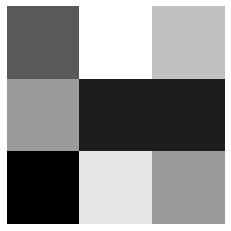

In [4]:
plt.imshow(poison_mask.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

Label: Ankle boot


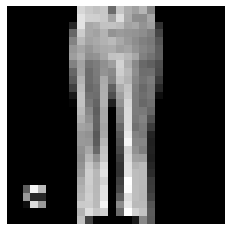

In [5]:
print(f"Label: {LABEL_NAMES[y_train[src_img_indices][rand_indices][0]]}")
plt.imshow(x_train[src_img_indices][rand_indices][0,...,0], cmap="gray")
plt.axis("off")
plt.show()

Here the mask was randomly placed but it can be configured to lie wherever on the image. Depending on the where the object is in relation to the frame, this could potentially have an impact on the features extracted and affect classification.

### Build and train the model
I've opted for a simple CNN network akin to the example [here](https://keras.io/examples/cifar10_cnn/). This will act as our classification model for the preliminary poisoning and training phase as well as the pretrained feature extraction network in our generative, CVAE, phase.

In [6]:
tf.keras.backend.clear_session()
model = models.build_cnn_classifier(INPUT_SHAPE, NUM_HIDDEN_UNITS, NUM_CLASSES)
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "cnn_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
feature_extractor (Model)    (None, 5, 5, 64)          64992     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 168,106
Trainable params: 168,106
Non-trainable params: 0
______________________________________________

In [7]:
es_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)
mc_cb = tf.keras.callbacks.ModelCheckpoint(CNN_MODEL_PATH, save_best_only=True)

model.fit(
    x_train,
    y_train,
    epochs=60,
    validation_data=(x_test, y_test),
    callbacks=[es_cb, mc_cb],
    verbose=0,
)
print(f"Model test accuracy: {model.evaluate(x_test, y_test)[-1] * 100 :0.4}%")

313/313 [==============================] - 0s 2ms/step - loss: 0.2426 - accuracy: 0.9117
Model test accuracy: 91.17%


The model appears to have converged and has an accuracy near to our expeted ~91%. The remaining requirement is that is successfully recognize our poison mask when applied to a test image.

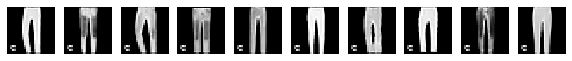

Predicted target class with 99.99% accuracy.


In [8]:
test_trousers, poison_mask = utils.poison_imgs(
    x_test[y_test == src_class], mask_size=3, mask_seed=RANDOM_SEED
)
preds = model.predict(test_trousers).argmax(axis=1)
utils.display_imgs(test_trousers[:10])
vals, counts = np.unique(preds, return_counts=True)
normalized_counts = counts / np.linalg.norm(counts)
target_test_acc = 100 * normalized_counts[vals == target_class].squeeze()
print(f"Predicted target class with {target_test_acc:.4}% accuracy.")

Looks like our model has learned to identify our poisoned source images with the target class!

## Analyze Activations

### Get the activations of our clean test data
We are assuming that an adversary has poisoned our train set but left our test set unscathed or that we have a known set of clean images witheld specifically for testing if our data is poisoned.

In [9]:
test_activations = utils.get_activations(x_test, model, layer_names=["dense"])

### Embed the data in 2D and plot
Similar to Chen et al. [CITATION NEEDED] we plot the activations in 2D and analyse various pairings and the clusters they form. Here we aren't running any clustering algorithms but rather just plotting the data to see how well separated the classes are in feature space.

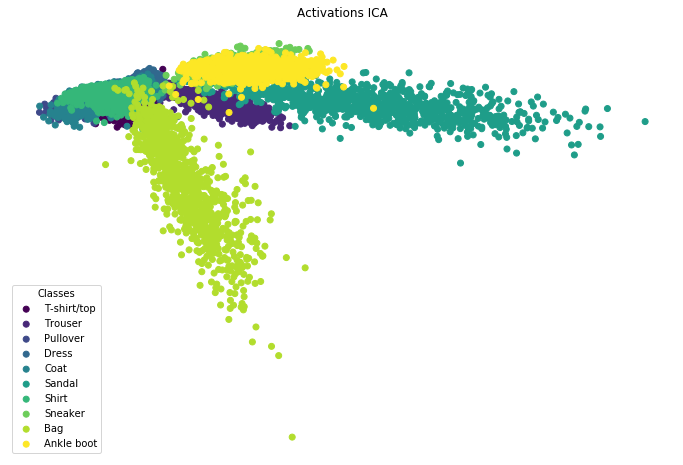

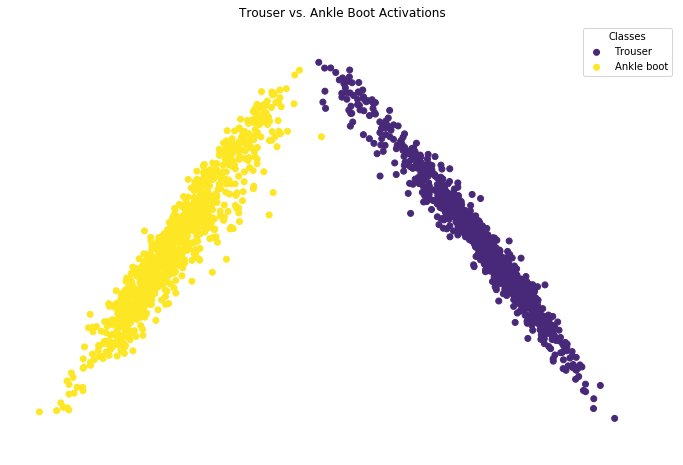

In [10]:
utils.plot_activations_ica(test_activations, y_test, LABEL_NAMES)
utils.plot_a_vs_b(test_activations, src_class, target_class, y_test, LABEL_NAMES)

We can see that in the second plot, the classes are well separated when ICA is performed and they are plotted in 2D.

### Visualize activations
We can see the activations for classes are fairly unique. The layers in the plot show the activations for all 10 classes distinctly.

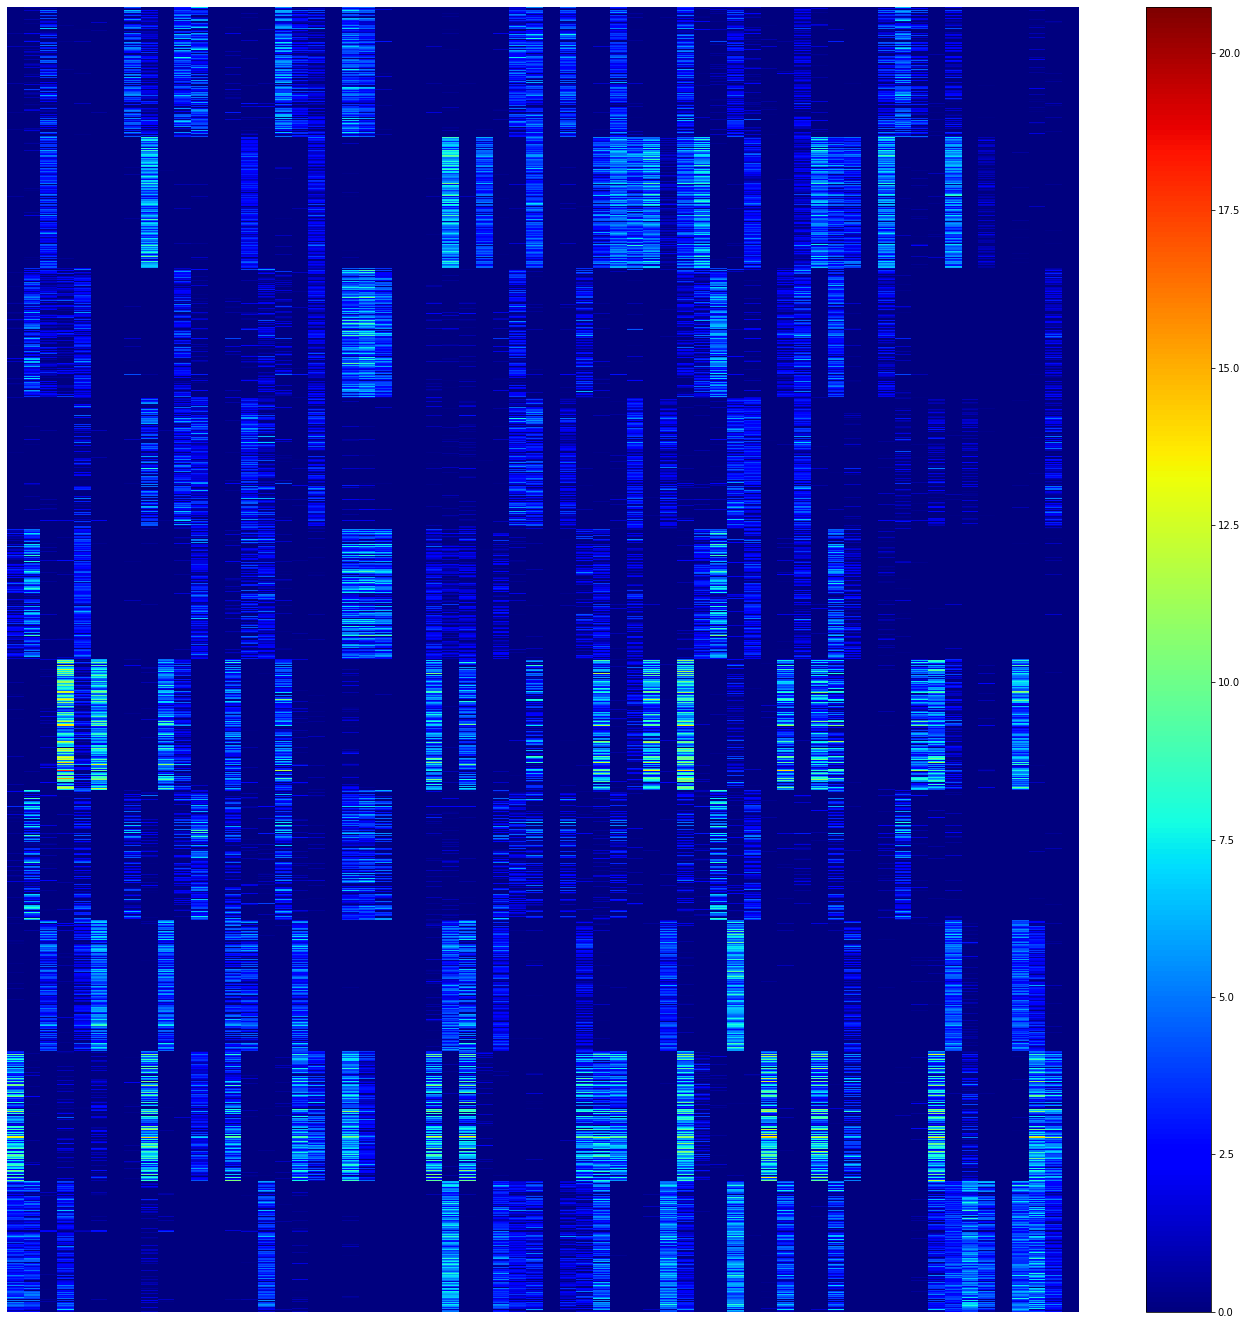

In [11]:
utils.plot_activation_hmap(test_activations, y_test, cmap="jet")

### Now lets do the same with our poisoned images

In [12]:
train_activations = utils.get_activations(x_train, model, layer_names=["dense"])

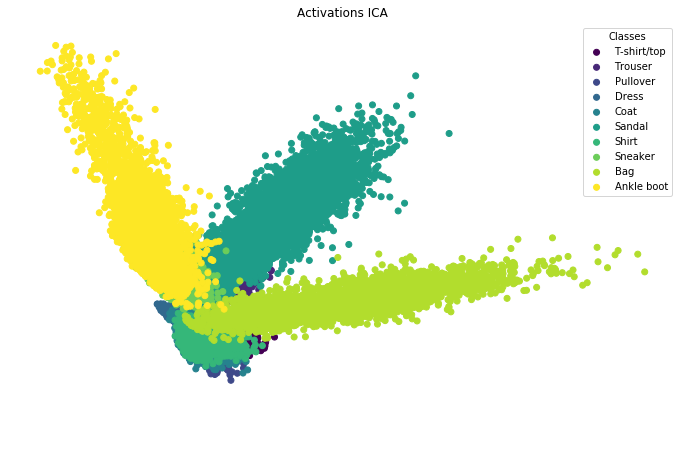

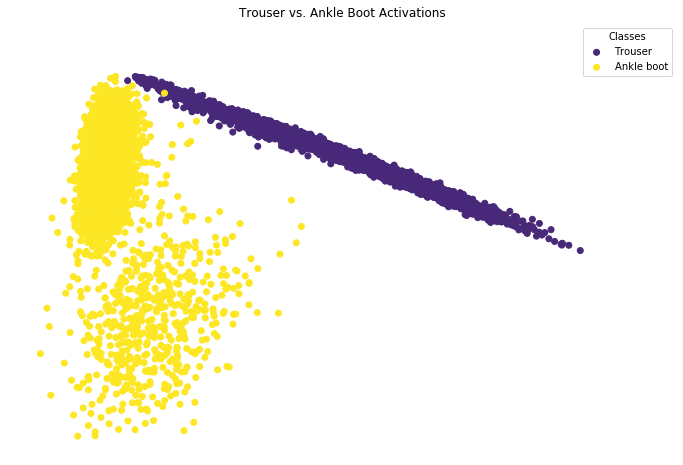

In [13]:
utils.plot_activations_ica(train_activations, y_train, LABEL_NAMES)
utils.plot_a_vs_b(train_activations, src_class, target_class, y_train, LABEL_NAMES)

In the bottom plot we can see the phenomenon predicted and emperically observed by Chen et al. The target class for the poisoned images is distincly split into 2 separate clusters in the projected space. We can see that the pure source and target classes are well separated as they were previously but that the classifier pushes the poisoned images into an area of the latent space all their own.

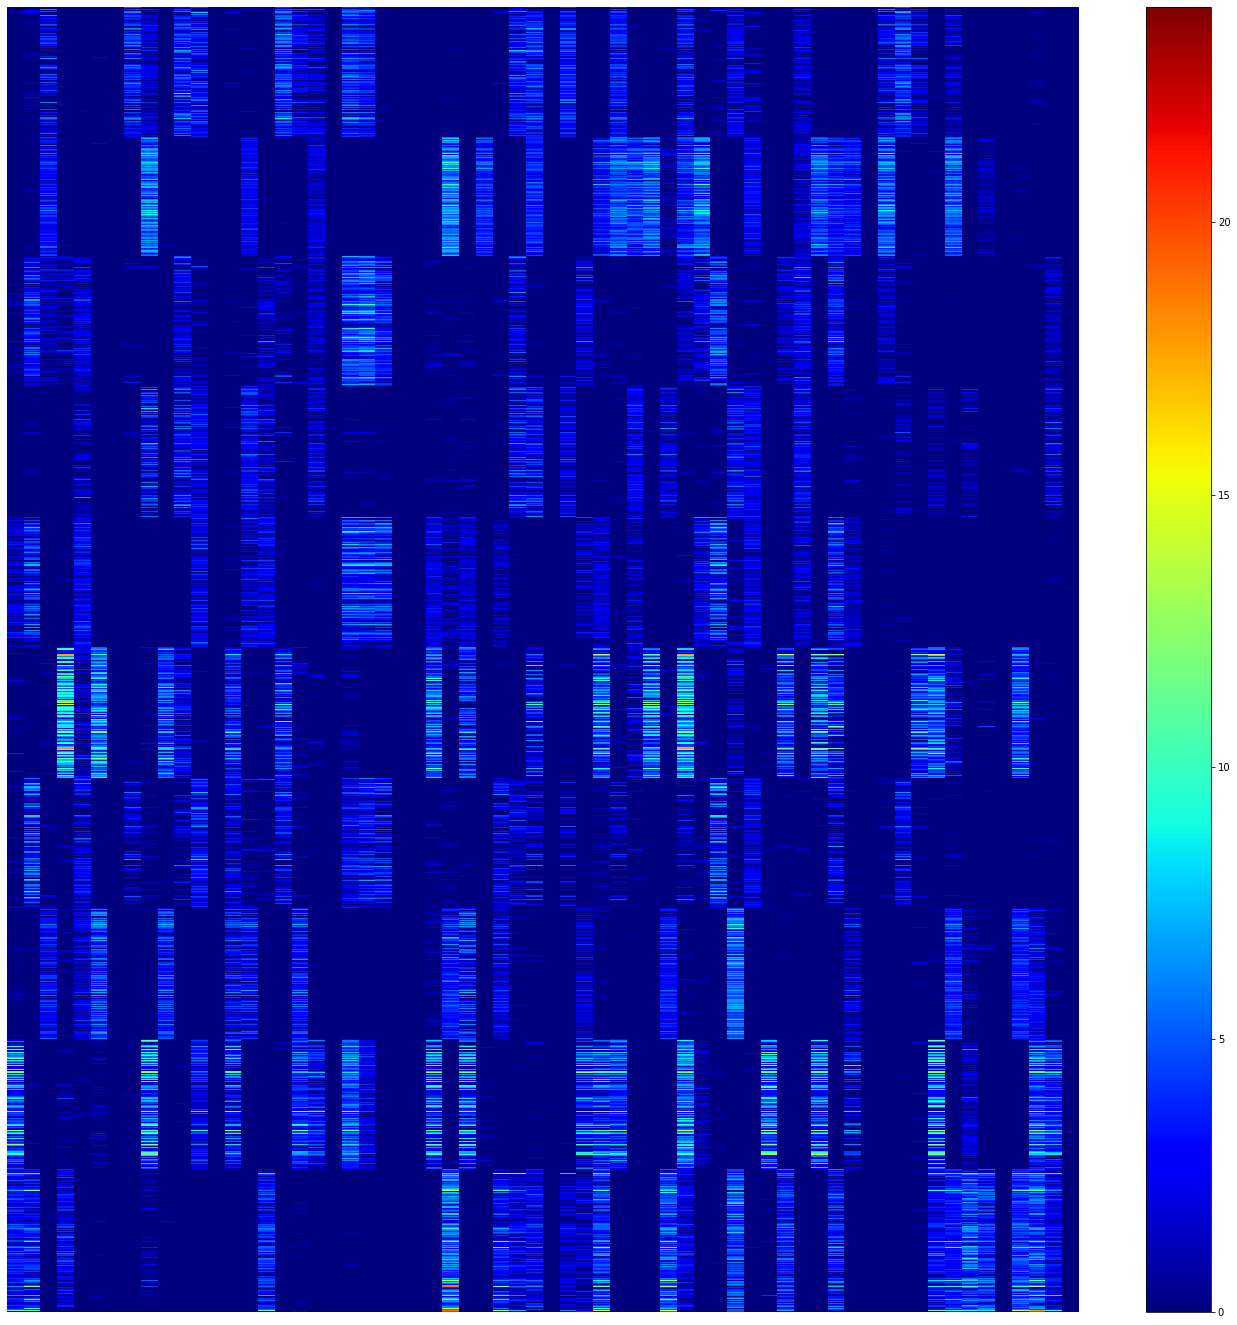

In [14]:
utils.plot_activation_hmap(train_activations, y_train, cmap="jet")

It's a bit hard to see since they are spread out but the activations for the last class (Ankle boot) have a few distortions. There are units lighting up in some that don't appear in others. Let's take a closer look!

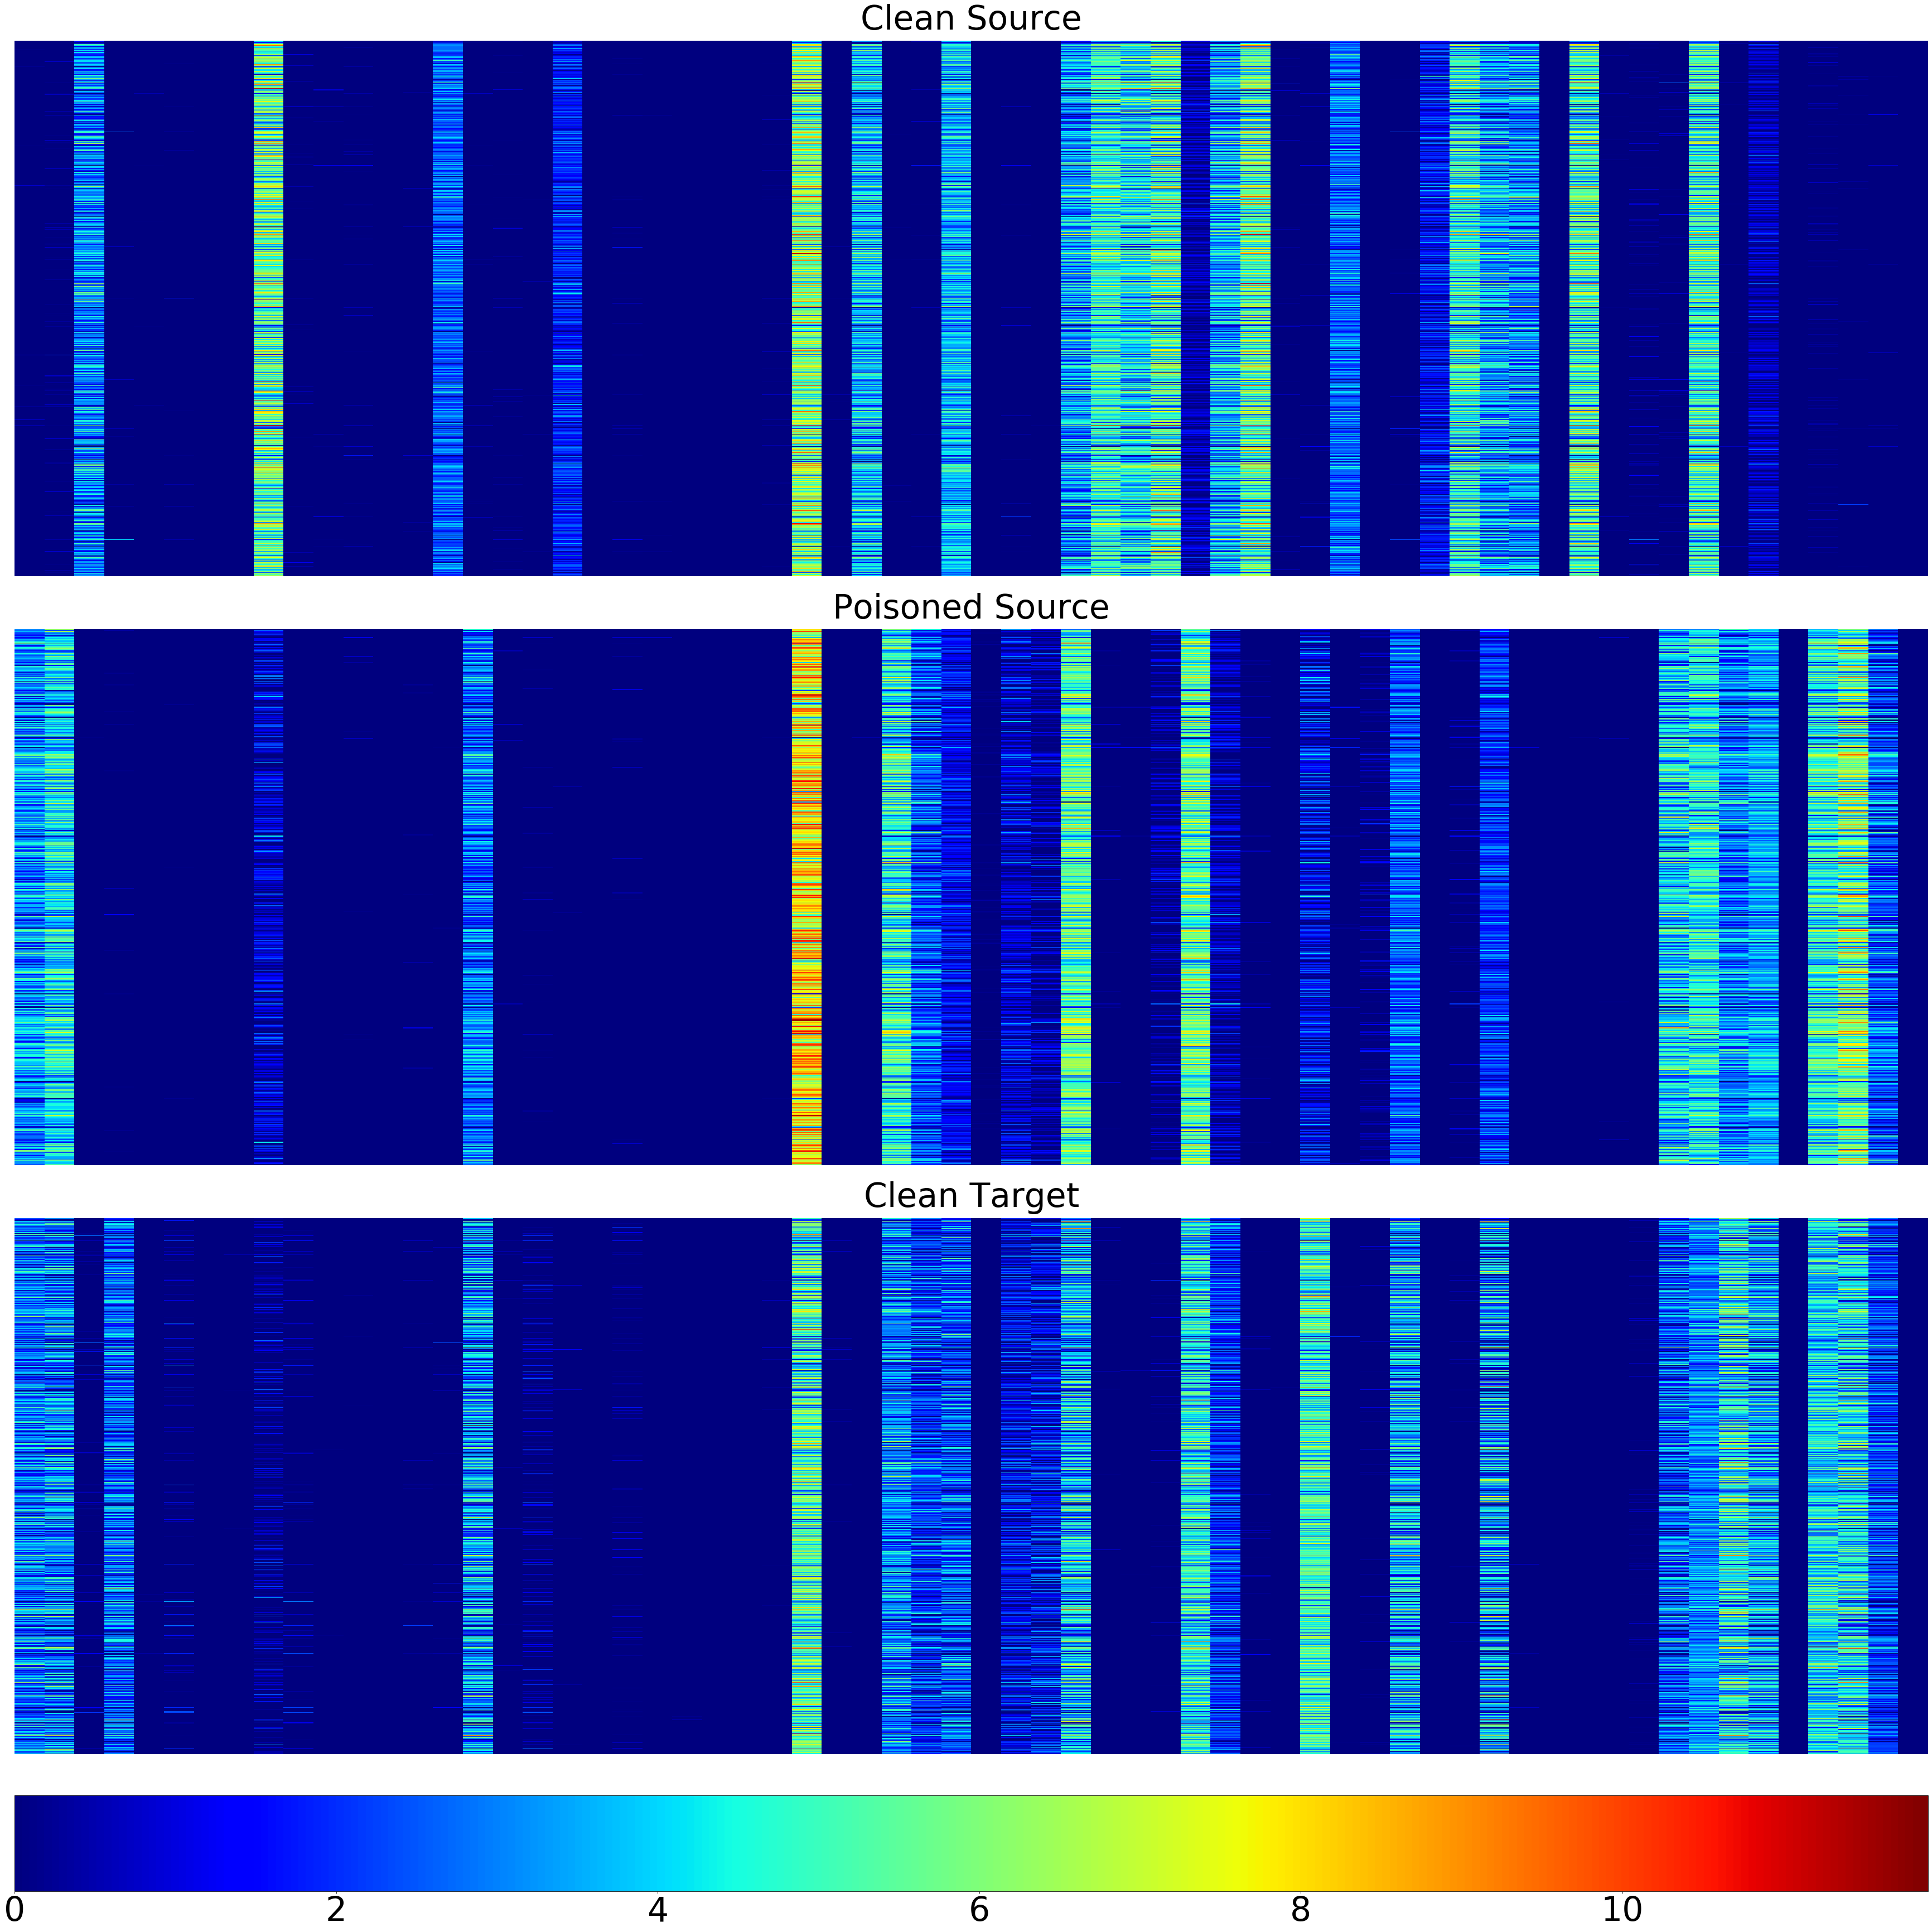

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(48, 48), constrained_layout=True)
acts_to_plot = [
    train_activations[m]
    for m in [clean_src_indices, src_img_indices[rand_indices], original_target_indices]
]
titles = ["Clean Source", "Poisoned Source", "Clean Target"]
for ax, (acts, title) in zip(axes.flat, zip(acts_to_plot, titles)):
    hmap = ax.imshow(acts, cmap="jet", aspect="auto")
    ax.set_title(title, size=60, pad=20)
    ax.axis("off")
cbar = fig.colorbar(hmap, ax=axes.ravel().tolist(), orientation="horizontal")
cbar.ax.tick_params(labelsize=60)
plt.show()

We can see that the activations are a very strongly activated in the poisoned source data when compared to either the clean target or source data. The model is clearly picking up additional features like our mask. In the next phase, we'll use this pretrained feature exctraction network to train a CVAE conditioned on the extracted features and the label. The goal is to use the reconstruction loss of the CVAE to determine the best label for each image. We can use the best label to identify poisoned images by locating discrepancies between it and the assigned label.

## Poison Detection

My idea for detecting poison in an image data set is to train a Conditional Variational Autoencoder (CVAE) to learn a distribution of activations in the latent space as well as to decode them. The model will take as features an image as well as it's class label. It will then encode the features into distribution in the latent space. This distribution is sampled and combined again with the class label and sent through the decoder. The decoder learns to reconstruct the original image after it has been forced through an information bottleneck in the form of the latent vector. 

The idea is that training the generative model on a small amount of verifiably clean data will allow it to learn a high correlation between the class label and the "style" to apply to the latent vector while decoding. This correlation will be evidenced by the ability for the model to successfully apply the class "style" to identical latent space sample vectors. The generative model would produce high reconstruction loss when given a poisoned image due to the fact that it's label and latent space representation would cause it to be incorrectly reconstructed.

In [16]:
# CVAE specific config options
BATCH_SIZE = 256
LATENT_DIM = 4
BETA = 10
CVAE_MODEL_PATH = f"cvae_L{LATENT_DIM}_B{BETA}.h5"
GEN_OUT_DIR = Path("./gen_imgs")
GEN_OUT_DIR.mkdir(exist_ok=True)

In [88]:
num_shots = 15
_, x_verified, _, y_verified = train_test_split(
    x_test,
    y_test,
    test_size=num_shots * NUM_CLASSES,
    stratify=y_test,
    random_state=RANDOM_SEED,
)
np.unique(y_verified, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15]))

In [89]:
# Our CVAE is trianed on image+label, image pairs so we need to change the preprocessing
def _preprocess(image, label):
    label = tf.one_hot(tf.squeeze(label), NUM_CLASSES)
    return {"input_enc": image, "input_enc_cond": label}, image

train_ds = tf.data.Dataset.from_tensor_slices((x_verified, y_verified))
test_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_ds = (
    train_ds.map(_preprocess)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
    .shuffle(int(1e4))
)

test_ds = (
    test_ds.map(_preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
)

### CVAE Model

Technically we are creating a $\beta$-CVAE. The $\beta$ factor controls the effect the KL divergence has on the overall loss. It serves to encourage disentanglement between attributes in the latent space representation of an image. For instance the width, height, color, pattern, etc. [CITATION_NEEDED]

In [90]:
def build_encoder(input_shape, latent_dim, prior, beta=1.0, cond_shape=None):
    num_dense_units = tfpl.MultivariateNormalTriL.params_size(latent_dim)
    kl_regularizer = tfpl.KLDivergenceRegularizer(prior, weight=beta)
    feature_extractor = models.build_feature_extractor(input_shape)
    x_in = tfkl.Input(input_shape, name="input_enc")
    cond_in = tfkl.Input(cond_shape, name="input_enc_cond")
    inputs = [x_in, cond_in]

    # Add condition vector as additional image channel
    #     fe_input_shape = input_shape[:-1] + (input_shape[-1] + cond_shape[-1],)
    #     feature_extractor = models.build_feature_extractor(fe_input_shape)
    #     cond = tfkl.Reshape((1, 1, cond_shape[0]))(cond_in)
    #     cond = tfkl.UpSampling2D(input_shape[:2])(cond)
    #     x = tfkl.Concatenate(axis=-1)([x_in, cond])
    
    # Get CNN features
    x = feature_extractor(x_in)
    x = tfkl.Flatten()(x)
    
    # Add condition vector to extracted features
    x = tfkl.Concatenate()([x, cond_in])

    # Assume the features are independent
    #     x = tfkl.Dense(latent_dim * 2)(x)
    #     loc, scale = tf.split(x, 2, axis=1)
    #     x = tfpl.DistributionLambda(
    #         make_distribution_fn=lambda x: tfd.MultivariateNormalDiag(
    #             loc=x[0], scale_diag=tf.nn.softplus(x[1]) + 1e-6
    #         ),
    #         activity_regularizer=kl_regularizer,
    #     )([loc, scale])

    # Assume the features are correlated
    x = tfkl.Dense(num_dense_units)(x)
    x = tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)(x)
    return tfk.Model(inputs=inputs, outputs=[x, cond_in], name="encoder")


def build_decoder(latent_dim, base_shape, output_activation=None, cond_shape=None):
    inputs = tfkl.Input((latent_dim,))
    x_in = tfkl.Input(latent_dim, name="input_dec")
    cond_in = tfkl.Input(cond_shape, name="input_dec_cond")
    inputs = [x_in, cond_in]
    
    # Add the condition vector to latent representation
    x = tfkl.Concatenate()([x_in, cond_in])
    x = tfkl.Dense(tf.reduce_prod(base_shape), activation="relu")(x)
    x = tfkl.Reshape(base_shape)(x)
    
    # Conv transpose back to original shape
    x = tfkl.Conv2DTranspose(64, 5, strides=2, padding="same", activation="relu")(x)
    x = tfkl.Conv2DTranspose(32, 5, strides=2, padding="same", activation="relu")(x)
    x = tfkl.Conv2D(
        filters=1,
        kernel_size=5,
        strides=1,
        padding="same",
        activation=output_activation,
    )(x)
    return tfk.Model(inputs=inputs, outputs=x, name="decoder")

In [91]:
tfk.backend.clear_session()

prior = tfd.Independent(
    tfd.Normal(loc=tf.zeros(LATENT_DIM), scale=1), reinterpreted_batch_ndims=1
)

encoder = build_encoder(INPUT_SHAPE, LATENT_DIM, prior, BETA, cond_shape=(NUM_CLASSES,))
decoder = build_decoder(
    LATENT_DIM, (7, 7, 64), "sigmoid", cond_shape=(NUM_CLASSES,)
)

# Load the pretrained feature extractor and prevent training it's weights
if Path(CNN_MODEL_PATH).exists():
    try:
        encoder.load_weights(CNN_MODEL_PATH, by_name=True, skip_mismatch=True)
    except ValueError as e:
        print(f"Could not load weights: {e}")
for layer in encoder.layers:
    if layer.name == "flatten":
        break
    layer.trainable = False

cvae = tfk.Model(inputs=encoder.inputs, outputs=decoder([encoder.outputs]))
cvae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
feature_extractor (Model)       (None, 5, 5, 64)     64992       input_enc[0][0]                  
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1600)         0           feature_extractor[1][0]          
__________________________________________________________________________________________________
input_enc_cond (InputLayer)     [(None, 10)]         0                                            
______________________________________________________________________________________________

### Train

In [92]:
cvae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=utils.negloglike)

si_cb = utils.SaveImages(decoder, prior.sample(10), NUM_CLASSES, GEN_OUT_DIR / "{}.png")

es_cb = tf.keras.callbacks.EarlyStopping(
#     monitor="val_loss", patience=5, restore_best_weights=True
    monitor="loss", patience=5, restore_best_weights=True
)
mc_cb = tf.keras.callbacks.ModelCheckpoint(CVAE_MODEL_PATH, save_best_only=True)

_ = cvae.fit(
    train_ds,
    epochs=1000,
#     validation_data=test_ds,
#     callbacks=[es_cb, mc_cb, si_cb],
    callbacks=[es_cb],
    verbose=0,
    workers=3,
)
cvae.evaluate(test_ds)

235/235 [==============================] - 2s 7ms/step - loss: 5620.0796


5620.07958984375

### Check reconstruction

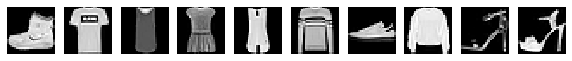

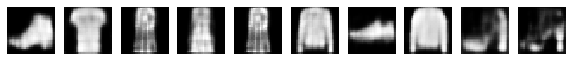

In [93]:
ys = tf.one_hot(y_train[:10], NUM_CLASSES)
xs = x_train[:10]
xhat = cvae((xs, ys))
utils.display_imgs(xs)
utils.display_imgs(xhat)

### Check generation

T-shirt/top


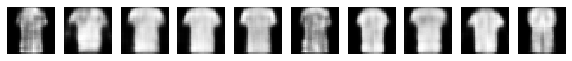

Trouser


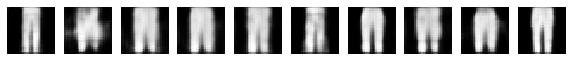

Pullover


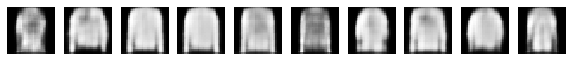

Dress


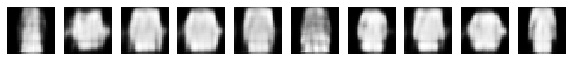

Coat


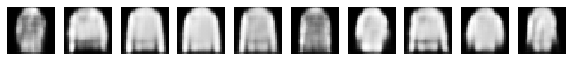

Sandal


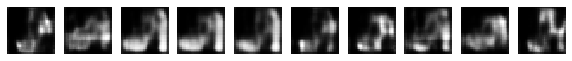

Shirt


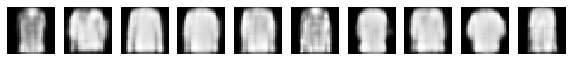

Sneaker


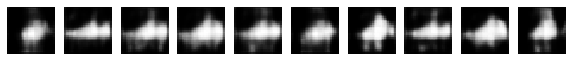

Bag


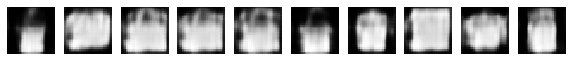

Ankle boot


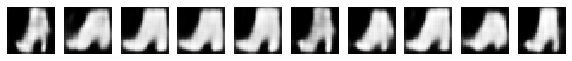

In [94]:
z = prior.sample(10)
for i in range(10):
    print(LABEL_NAMES[i])
    cond = tf.one_hot(i, NUM_CLASSES)[None]
    tiled_cond = tf.tile(cond, [z.shape[0], 1])
    xtilde = decoder([z, tiled_cond])
    utils.display_imgs(xtilde)

### Let's look for some poisoned data
We'll run our newly trained CVAE on our training set and calculate the reconstruction loss. We would expect higher reconstruction loss for poisoned images due to the fact that they are fed to the encoder with a label that belongs to another class. The generative model should output reconstructions that are far from the source class in pixel space since it has learned to highly correlate the label with the reconstruction

In [95]:
ys_oh = tf.one_hot(y_train, NUM_CLASSES)
xhats = cvae.predict((x_train, ys_oh)).squeeze()
loss = utils.negloglike(x_train, xhats)
sorted_loss = loss.numpy().argsort()[::-1]

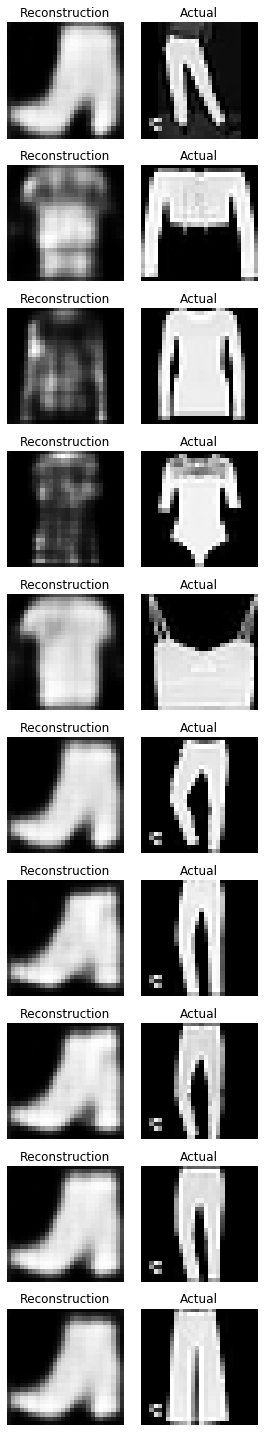

In [96]:
num_imgs = 10
fig, ax = plt.subplots(num_imgs, 2, figsize=(4, 2*num_imgs))
for i in range(num_imgs):
    idx = sorted_loss[i]
    ax[i, 0].imshow(xhats[idx], cmap="gray")
    ax[i, 1].imshow(x_train[idx].squeeze(), cmap="gray")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 0].set_title("Reconstruction")
    ax[i, 1].set_title("Actual")
plt.tight_layout()
plt.show()
plt.close()

We can see that of our top 10 worst reconstructions we already see some of our poisoned trousers. What's better is the reconstructions look like the target class! It looks as though other outlier data points for other classes have appeared as well. We can see the bags and tops that appear are atypical to the generated examples.

Now that we see there is clearly something wrong with these trouser images and their labels, let's narrow in on the target class.

In [ ]:
target_mask = y_train == target_class
ys_oh = tf.one_hot(y_train[target_mask], NUM_CLASSES)
xhats = cvae.predict((x_train[target_mask], ys_oh)).squeeze()
loss = utils.negloglike(x_train[target_mask], xhats)
sorted_loss = loss.numpy().argsort()[::-1]

In [ ]:
fig, ax = plt.subplots(10, 2, figsize=(4, 20))
for i in range(10):
    idx = sorted_loss[i]
    ax[i, 0].imshow(xhats[idx], cmap="gray")
    ax[i, 1].imshow(x_train[target_mask][idx].squeeze(), cmap="gray")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 0].set_title("Reconstruction")
    ax[i, 1].set_title("Actual")
plt.tight_layout()
plt.show()
plt.close()

Bingo! Now we've narrowed in on our poisoned data and can go about correcting it.

## Conclusion
We've seen that detecting poison in a data set can be a nontrivial task. The method put forth by Chen et al. is very powerful when the poison is applied in pixel space as it is detectable in the latent space. I extended their concept of searching the latent space for features of poisoned data by training a generative model to learn the distribution of the latent space under normal operation. The CVAE model used both the image as well as the class label as a condition when learning. The class label is typically highly correlated with the reconstruction. By forcing the images through a tight bottleneck with the original feature extractor, we save computation and force the encoder/decoder to rely heavily on the class label in it's reconstructions. At test time we see this leads to higher reconstruction loss on poisoned images as they are reconstructed more closely to their label and latent representation vs the image in pixel space.

## Bonus: Gif of the model learning to generate images

In [ ]:
import imageio
import IPython
import re

gif_fname = 'cvae.gif'
filenames = list(GEN_OUT_DIR.glob('*.png'))
filenames.sort(key=lambda f: int(re.sub('\D', '', str(f))))
imageio.mimsave(gif_fname, [imageio.imread(f) for f in filenames])
IPython.display.Image(filename=gif_fname)

As a slight aside, isn't it interesting that the CVAE (technically a $\beta\$-CVAE) model has disentangled the different traits of the latent vector well enough to create tall versions of the different classes when the vector encodes tall and wide when it encodes wide?